In [119]:
%run Helper.ipynb

Num GPUs Available:  1


In [6]:
# Load all images
images = load_images()

In [7]:
# Load all models
models = {}
for name, handle in ALL_MODELS.items():
    print('Loading model ' + name)
    
    # Set use of legacy code according to model
    set_legacy(False) if name != 'Faster R-CNN (OpenImages)' else set_legacy(True)
    print('Legacy set to ' + str(USE_LEGACY))
    
    models[name] = load_model(handle)

Loading model EfficientDet
Legacy set to False


Model loaded!
Loading model Faster R-CNN
Legacy set to False
Model loaded!
Loading model Faster R-CNN (OpenImages)
Legacy set to True
Model loaded!
Loading model CenterNet
Legacy set to False
Model loaded!


In [8]:
# Setup detections (which can be used to generate statistics later)
images_with_detection = {}

# Run detection for all models
for name, model in models.items():
    print('Running for model ' + name)
    
    # Set use of legacy code according to model
    set_legacy(False) if name != 'Faster R-CNN (OpenImages)' else set_legacy(True)
    print('Legacy set to ' + str(USE_LEGACY))
    
    # Run inference
    images_with_detection[name] = run_inference(images, model)

Running for model EfficientDet
Legacy set to False


Running for model Faster R-CNN
Legacy set to False


Running for model Faster R-CNN (OpenImages)
Legacy set to True


Running for model CenterNet
Legacy set to False


In [110]:
# Setup detected classes with count
detected_classes = {}

for name, model in models.items():
    print('Running for model ' + name)
    
    # Set use of legacy code according to model
    set_legacy(False) if name != 'Faster R-CNN (OpenImages)' else set_legacy(True)
    print('Legacy set to ' + str(USE_LEGACY))
    
    # Save generated detections for statistics
    detected_classes[name] = get_detections_for_images(images_with_detection[name])

Running for model EfficientDet
Legacy set to False
Running for model Faster R-CNN
Legacy set to False
Running for model Faster R-CNN (OpenImages)
Legacy set to True
Running for model CenterNet
Legacy set to False


In [10]:
for name, model in models.items():
    print('Running for model ' + name)
    
    # Set use of legacy code according to model
    set_legacy(False) if name != 'Faster R-CNN (OpenImages)' else set_legacy(True)
    print('Legacy set to ' + str(USE_LEGACY))
    
    # Draw detections on image
    draw_detections_on_images(images_with_detection[name])

Running for model EfficientDet
Legacy set to False


Running for model Faster R-CNN
Legacy set to False


Running for model Faster R-CNN (OpenImages)
Legacy set to True


Running for model CenterNet
Legacy set to False


In [11]:
for name, model in models.items():
    print('Running for model ' + name)
    
    # Set use of legacy code according to model
    set_legacy(False) if name != 'Faster R-CNN (OpenImages)' else set_legacy(True)
    print('Legacy set to ' + str(USE_LEGACY))
    
    # Save new images
    save_images(images_with_detection[name], name)

Running for model EfficientDet
Legacy set to False


Running for model Faster R-CNN
Legacy set to False


Running for model Faster R-CNN (OpenImages)
Legacy set to True


Running for model CenterNet
Legacy set to False


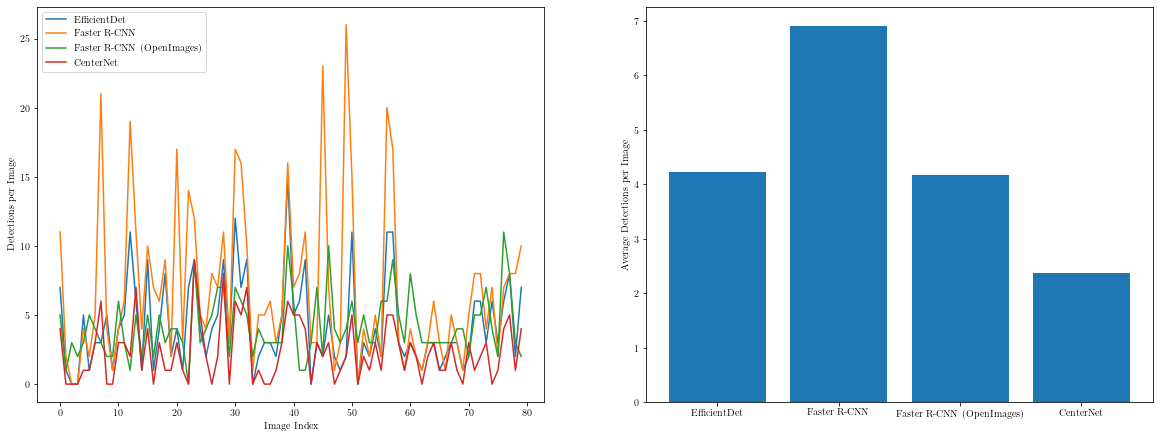

In [120]:
# Generate statistics
get_statistics_for_detections(detected_classes, len(images))
generate_detection_charts(detected_classes, len(images))

In [27]:
# generate_wordclouds_for_all_models(detections)

In [28]:
# generate_wordclouds_by_dataset(detections)

In [104]:
mscoco = [*detected_classes['EfficientDet'], *detected_classes['CenterNet'], *detected_classes['Faster R-CNN']]
mscoco_labels = get_detected_labels(mscoco)
openimages = detected_classes['Faster R-CNN (OpenImages)']
openimages_labels = get_detected_labels(openimages)

In [30]:
# Get babelnet entities for detected labels
get_entity_mapping(mscoco_labels)

get_entity_mapping(openimages_labels)

In [17]:
save_entity_mapping(mscoco_labels, 'outputs/statistics/mapped_entities_mscoco.csv')
save_entity_mapping(openimages_labels, 'outputs/statistics/mapped_entities_openimages.csv')

EfficientDet: 0.8962734741784038
CenterNet: 0.8008902077151335
OpenImages (Faster R-CNN): 0.8660449970396684
Faster R-CNN: 0.7621589561091341


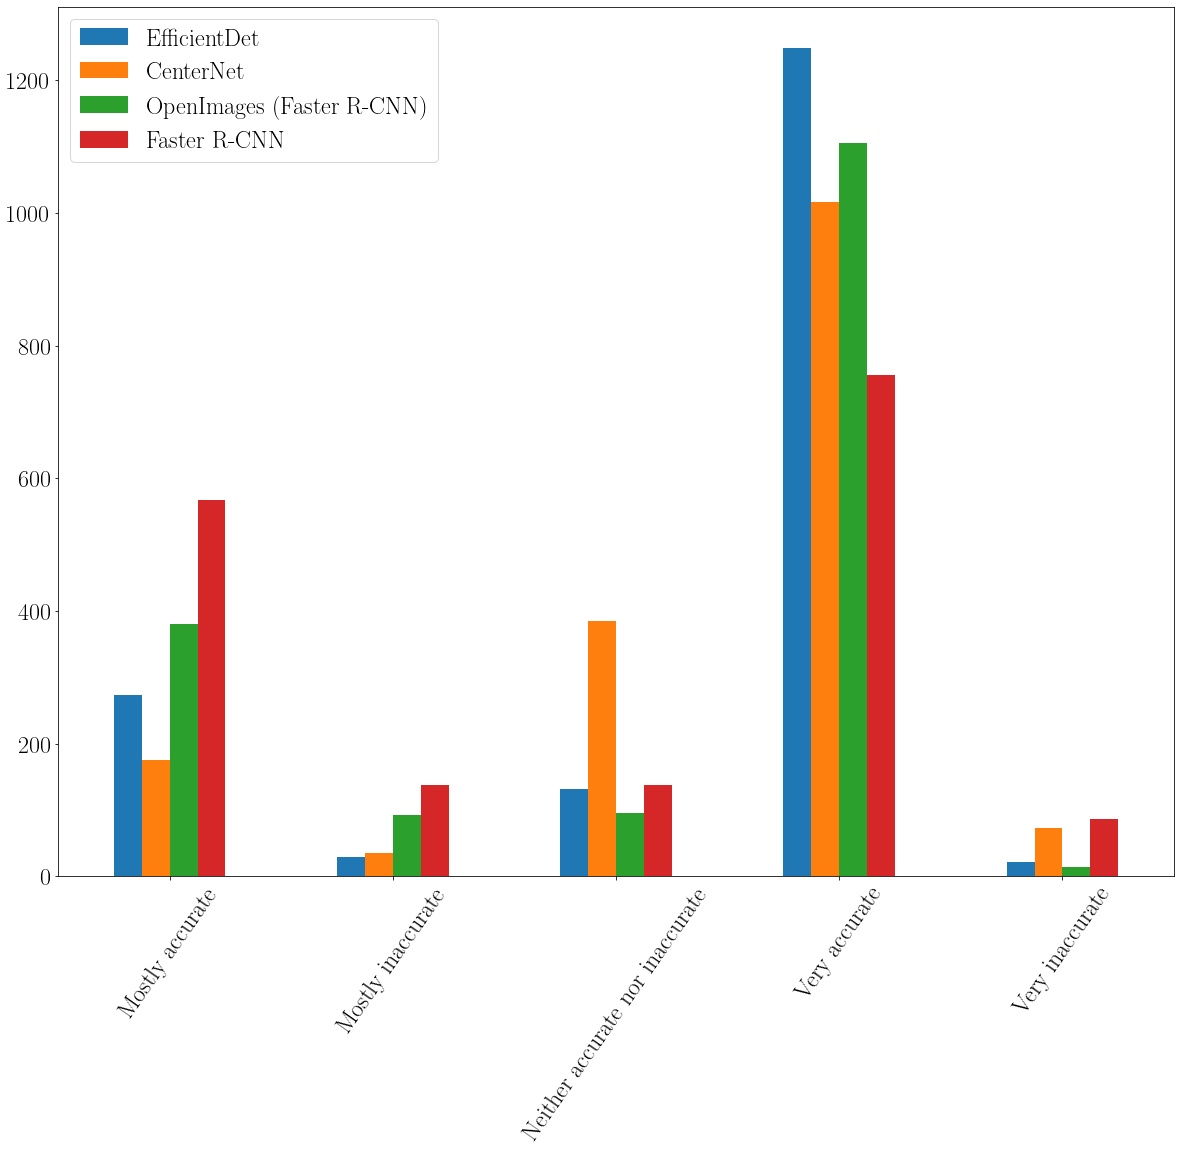

In [18]:
# Generate statistics from survey
detection_results = pd.read_csv("outputs/statistics/results_detection.csv")

mapping = {
    'Very accurate': 1,
    'Mostly accurate': 0.75,
    'Neither accurate nor inaccurate': 0.5,
    'Mostly inaccurate': 0.25,
    'Very inaccurate': 0
}

series = {}
for model_shortcut in ['EfficientDet', 'CenterNet', 'OpenImages (Faster R-CNN)', 'Faster R-CNN']:
    model_columns = detection_results.filter(like=model_shortcut[0]).columns
    
    mappings = pd.Series(dtype='float64')
    for column in model_columns:
        mappings = pd.concat([mappings, detection_results[column].dropna().map(lambda x: mapping[x])])
    
    series[model_shortcut] = detection_results[model_columns.array].apply(pd.value_counts).sum(axis=1)
    
    print(model_shortcut + ': ' + str(mappings.mean()))
    
plot = pd.DataFrame(series).plot(kind='bar', figsize=(20,16), fontsize=24)
plot.legend(prop={'size': 24})

for tick in plot.get_xticklabels():
    tick.set_rotation(55)

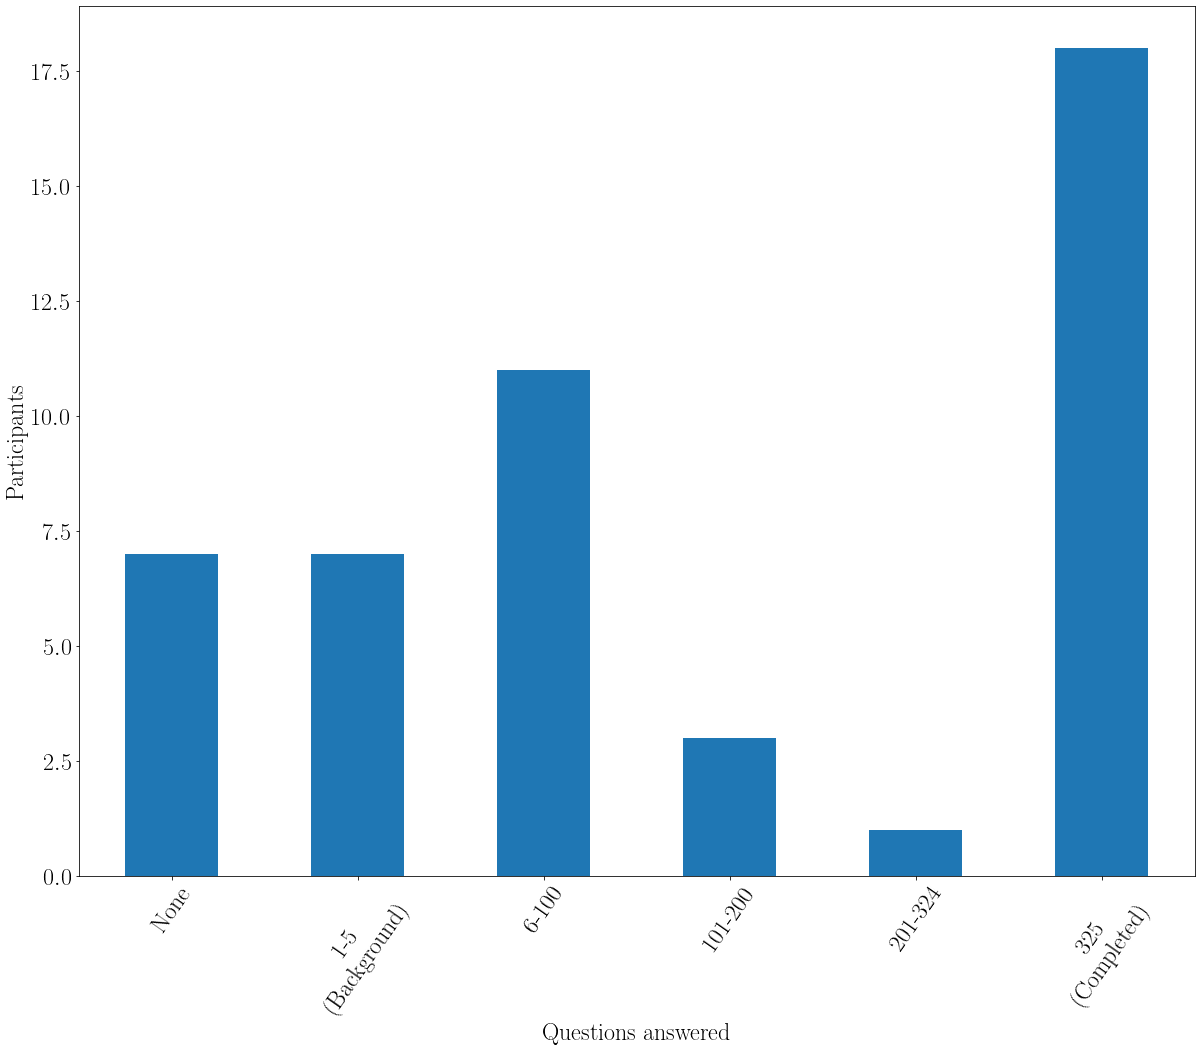

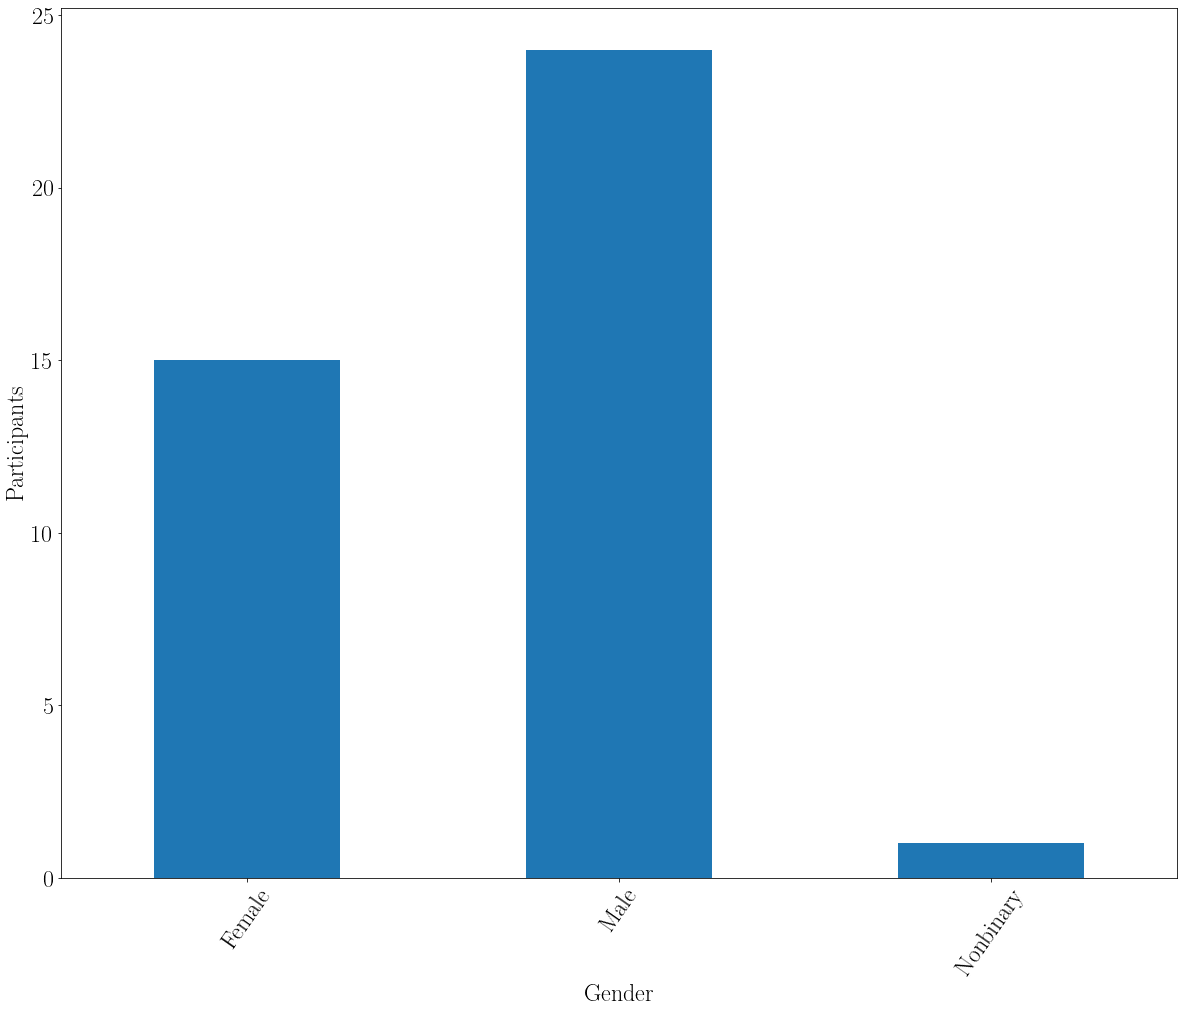

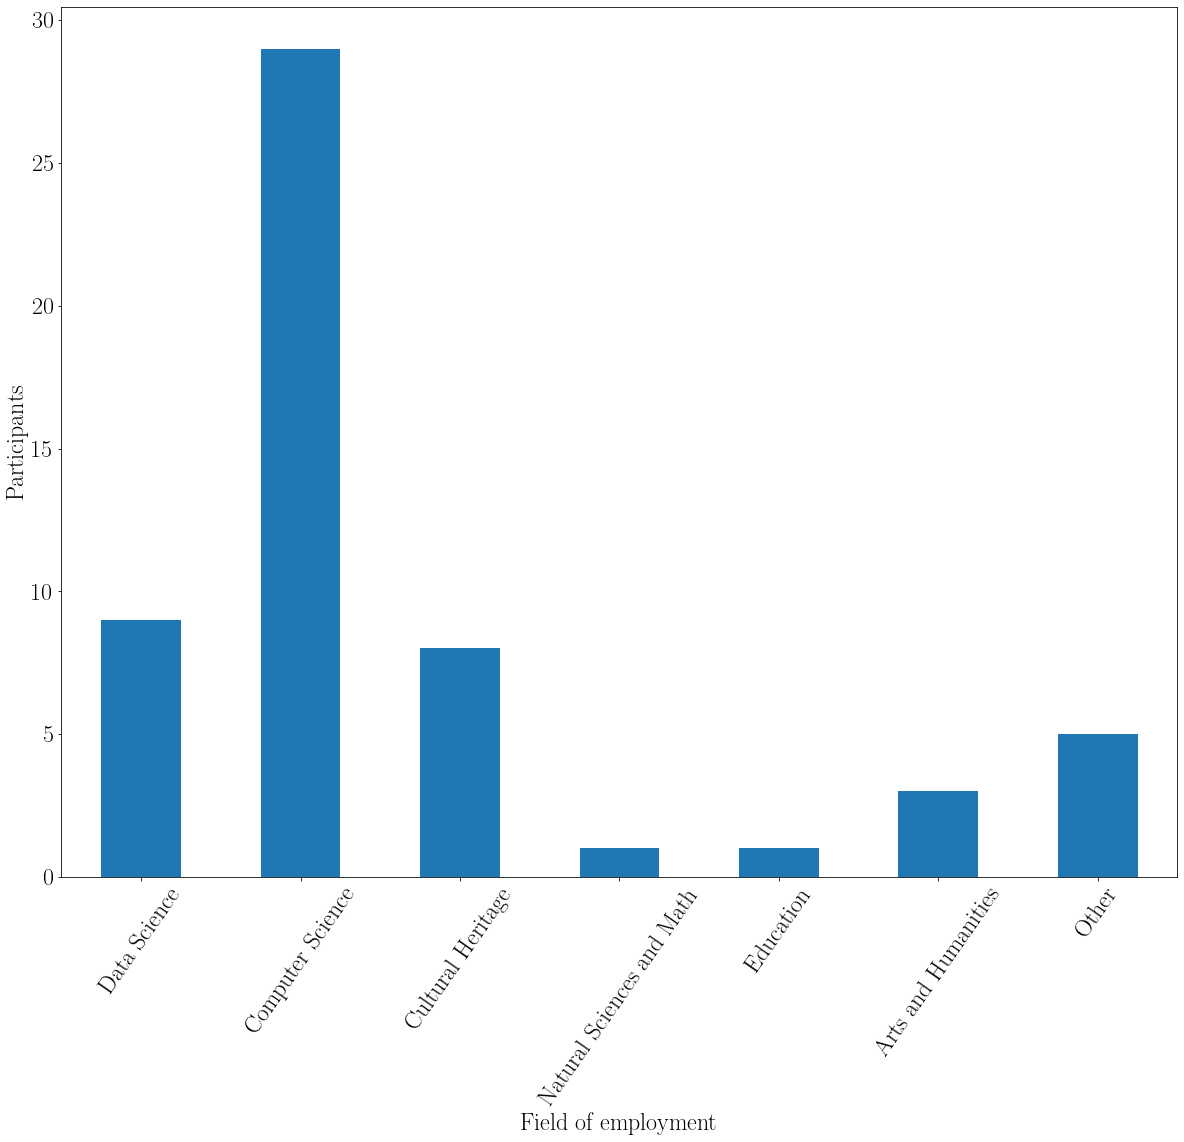

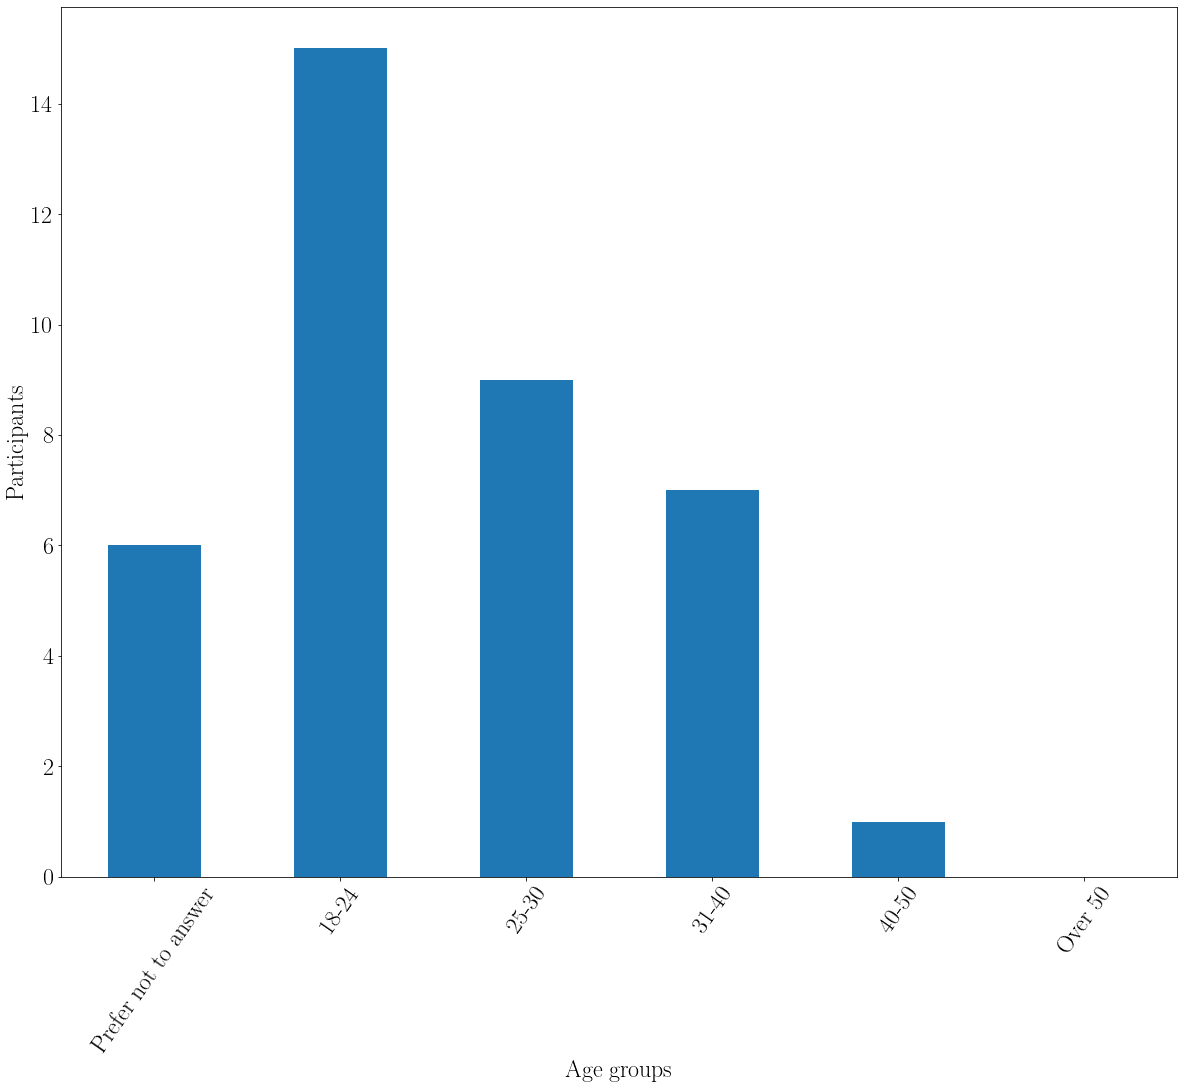

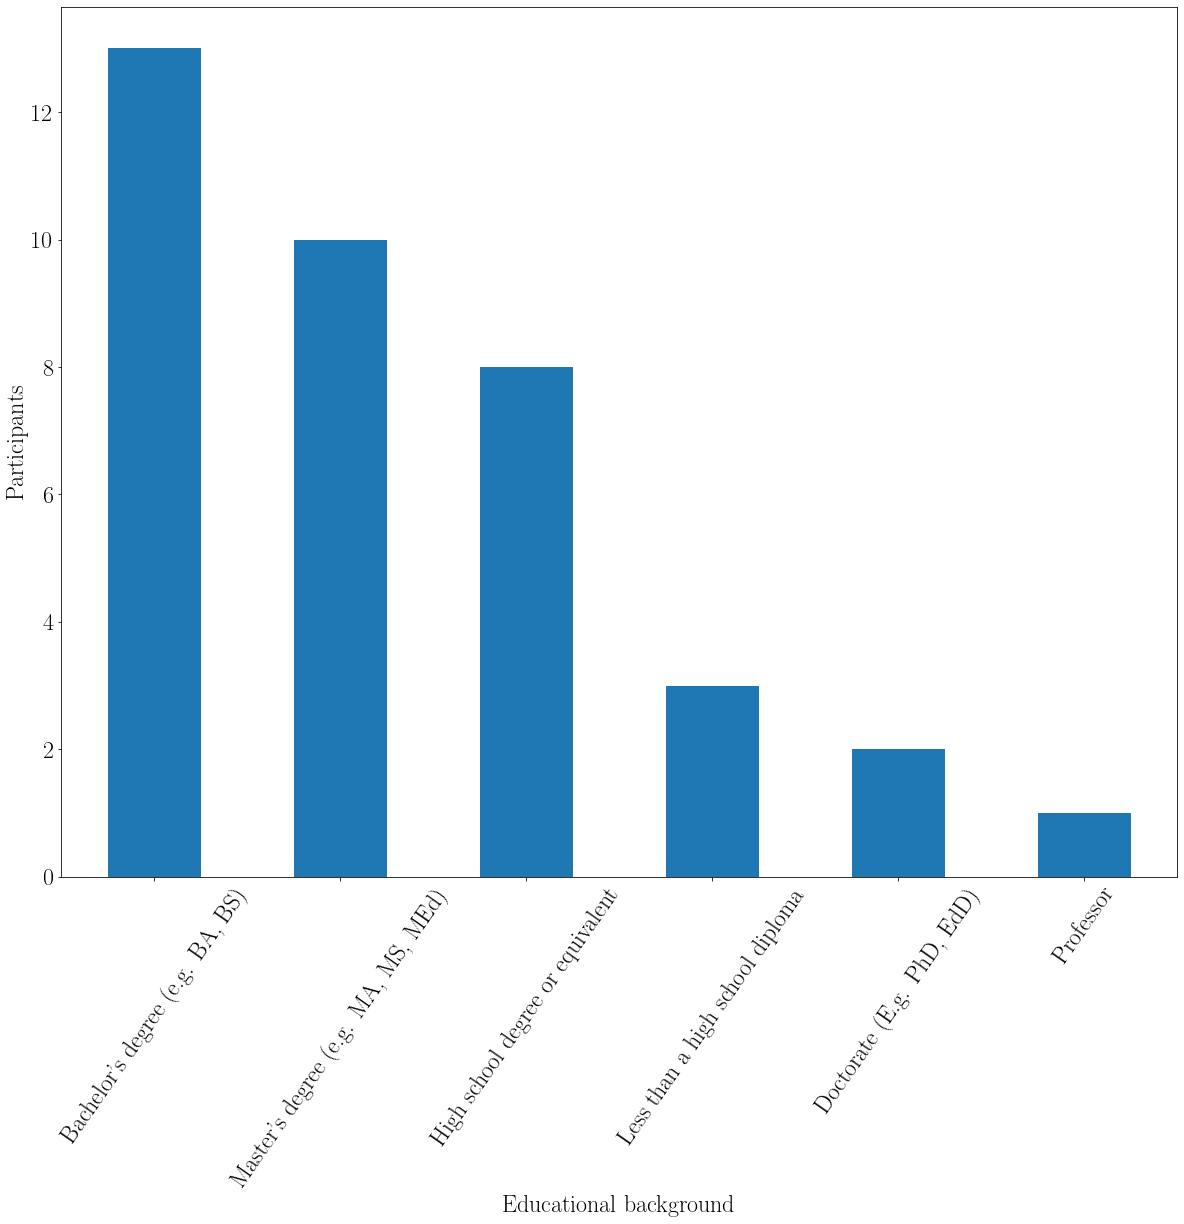

In [20]:
# Statistics on participant backgrounds
background_results = pd.read_csv("outputs/statistics/results_background.csv")

# Plot statistics
if not background_results.empty:
    generate_participant_statistics(background_results)

In [160]:
# Generate RDF information from object detection
from rdflib import Graph, Literal, RDF, URIRef, Namespace
from rdflib.namespace import FOAF, OWL, RDFS, XSD
from uuid import uuid4
DCMITYPE = Namespace('http://purl.org/dc/dcmitype/')
OWN = Namespace('http://example.org/')

def generate_uri(filename):
    return URIRef('http://example.org/' + parse.quote_plus(filename))

g = Graph()

sample = detected_classes['EfficientDet'][0]

for filename in sample.keys():
    imageURI = generate_uri(filename)
    g.add((imageURI, RDF.type, OWN.Image))
    
    for label, detection in sample[filename].items():
        for index, box in enumerate(detection['boxes']):
            boxURI = generate_uri(str(uuid4()))
            g.add((boxURI, RDF.type, OWN.BoundingBox))
            g.add((boxURI, OWN.yMin, Literal(box[0], datatype=XSD.float)))
            g.add((boxURI, OWN.xMin, Literal(box[1], datatype=XSD.float)))
            g.add((boxURI, OWN.yMax, Literal(box[2], datatype=XSD.float)))
            g.add((boxURI, OWN.xMax, Literal(box[3], datatype=XSD.float)))
            g.add((boxURI, OWN.confidence, Literal(detection['scores'][index], datatype=XSD.float)))
            g.add((boxURI, RDFS.label, Literal(label, lang='en')))
            
print(g.serialize(format='n3'))

@prefix ns1: <http://example.org/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ns1:3a26e6b6-e01c-448a-8ded-0e9ccd57764e a ns1:BoundingBox ;
    rdfs:label "person"@en ;
    ns1:confidence "0.5213591"^^xsd:float ;
    ns1:xMax "0.3117965"^^xsd:float ;
    ns1:xMin "0.25744236"^^xsd:float ;
    ns1:yMax "0.70653594"^^xsd:float ;
    ns1:yMin "0.4889086"^^xsd:float .

ns1:7b82b09c-57ad-473f-83ca-295dbf53a1b8 a ns1:BoundingBox ;
    rdfs:label "person"@en ;
    ns1:confidence "0.53414565"^^xsd:float ;
    ns1:xMax "0.49057606"^^xsd:float ;
    ns1:xMin "0.41799048"^^xsd:float ;
    ns1:yMax "0.8325062"^^xsd:float ;
    ns1:yMin "0.72060376"^^xsd:float .

ns1:7cb611b6-af7b-4876-b118-e8fa370577ab a ns1:BoundingBox ;
    rdfs:label "person"@en ;
    ns1:confidence "0.5375312"^^xsd:float ;
    ns1:xMax "0.4020827"^^xsd:float ;
    ns1:xMin "0.33310667"^^xsd:float ;
    ns1:yMax "0.8429686"^^xsd:float ;
    ns1:yMin "0.7388914"^^